# Visión por Computador - Práctica 3
## Cámara, geometría epipolar y reconstrucción estérea

### Estimación de la matriz de una cámara a partir del conjunto de puntos en correspondencias.

##### a) Generar la matriz de una cámara finita P a partir de valores aleatorios en [0,1] . Verificar si representa una cámara finita y en ese caso quedársela.
##### b) Suponer un patrón de puntos del mundo 3D compuesto por el conjunto de puntos con coordenadas $\{(0,x_1,x_2)$ y $(x_2,x_1,0)$, para $x_1=0.1:0.1:1$ y $x_2=0.1:0.1:1\}$. Esto supone una rejilla de puntos en dos planos distintos ortogonales.
##### c) Proyectar el conjunto de puntos del mundo con la cámara simulada y obtener las coordenadas píxel de su proyección.
##### d) Implementar el algoritmo DLT para estimar la cámara P a partir de los puntos 3D y sus proyecciones en la imagen.
##### e) Calcular el error de la estimación usando la norma de Frobenius (cuadrática).
##### f) Mostrar en una única imagen los puntos 3D proyectados con la cámara estimada y la cámara simulada.

*  **Apartado a:** para generar una cámara finita $P = K[R|T]$, donde $P=[KR|KT] = [M|M_T]$ simplemente tenemos que generar una matriz con números aleatorios y asegurarnos de que el determinante de $M$ sea distinto de 0. Al final, devolveremos una matriz de tamaño $3\times4$ con $det(M)\neq0$.

In [25]:
import cv2
import math
import numpy as np
import functions as fx

def generate_Pcamera():
    # La matriz cámara tiene la siguiente estructura:
    #              P =  K[R | T]
    # donde det(R) != 0, al igual que det(K) != 0, por
    # lo que podemos hacer que P = [KR | KT] = [M | M_4]

    # Generamos una matriz con valores aleatorios en el
    # intervalo [0,1)
    P_cam = np.random.rand(3,4)

    # Comprobamos si det(M) != 0. En caso de que no lo
    # sea, volvemos a generar una nueva matriz cámara.
    while not np.linalg.det(P_cam[0:3,0:3]):
        P_cam = np.random.rand(3,4)

    P_cam = P_cam / P_cam[-1,-2]
    return P_cam

* **Apartado b:** para generar los puntos con coordenadas $\{(0,x_1,x_2)$ y $(x_2,x_1,0)$, para $x_1=0.1:0.1:1$ y $x_2=0.1:0.1:1\}$, simplemente generamos dos arrays de 0 a 1 en intervalos de 0.1, que concatenaremos en forma de columna y añadiremos un cero por la izquierda o la derecha, según corresponda, generando puntos de la siguiente forma:
$$set_1 = \left[\begin{matrix}
  0 & 0 & 0 \\
  0 & 0 & 0.1 \\
   & \vdots &  \\
  0 & 0.1 & 0.5 \\
  & \vdots & \\
  0 & 0.9 & 0.9
 \end{matrix}\right] \qquad set_2 = \left[\begin{matrix}
  0 & 0 & 0 \\
  0 & 0.1 & 0 \\
   & \vdots &  \\
  0.1 & 0.1 & 0 \\
  & \vdots & \\
  0.9 & 0.9 & 0
 \end{matrix}\right]$$

In [26]:
def generate_points():
    # Generamos los valores de x1 y x2
    x1 = np.arange(start = 0, stop = 1,
                   step = 0.1, dtype=np.float64)
    x2 = np.arange(start = 0, stop = 1,
                   step = 0.1, dtype=np.float64)
    # Obtenemos una combinación de los puntos que hemos obtenido
    points2D = np.concatenate(np.array(np.meshgrid(x1,x2)).T)
    # Añadimos un cero por la izquierda y uno por la derecha respectivamente
    set1 = np.hstack((np.zeros(points2D.shape[0])[...,None], points2D))
    set2 = np.hstack((points2D, np.zeros(points2D.shape[0])[...,None]))
    # Y devolvemos un único conjunto de puntos
    return np.concatenate((set1, set2))

* **Apartado c:** para proyectar los puntos del mundo sobre el espacio 2D de la retina, tenemos que multiplicar los puntos del mundo por la matriz cámara que hemos generado, y normalizar estos puntos dividiendo por la última coordenada y devolviendo la coordenada $x_i$ e $y_i$ para el punto $X_i$ obteniendo así coordenadas 2D. Para ello, es necesario tener como entrada los puntos del mundo y la cámara, además de convertir estos puntos del mundo a coordenadas homogéneas. $$X' = PX = P \left[\begin{matrix}
x\\
y\\
z\\
1
\end{matrix}\right]$$ $$X'=\left[\begin{matrix}
x'\\
y'\\
z'
\end{matrix}\right] \qquad (u,v) = \left[\begin{matrix}\frac{x'}{z'}\\
\frac{y'}{z'}\end{matrix}\right]$$ Esta función devuelve las coordenadas homogéneas de los puntos del mundo y las coordenadas 2D de los puntos proyectados en la retina.

In [27]:
def project_points(points, camera):
    # Pasamos las coordenadas de los puntos a coordenadas homogéneas
    homogeneus_points = np.hstack((points, (np.ones(points.shape[0]))[...,None]))
    # Obtenemos una matriz vacía que serán las proyecciones
    # de los puntos al pasar por la cámara.
    projection = np.zeros(shape=(points.shape[0],2), dtype=np.float32)
    # Realizamos la multiplicación
    #    xy' = P * xy
    for i in range(homogeneus_points.shape[0]):
        point = np.dot(camera,homogeneus_points[i].T)
        projection[i,0] = point[0]/point[2]
        projection[i,1] = point[1]/point[2]

    # Devolvemos las proyecciones de los puntos
    return homogeneus_points, projection

* **Apartado d**: para realizar el algoritmo DLT (*Direct Linear Transformation*), partiremos de que conocemos los puntos reales del mundo (puntos xyz en coordenadas homogénas) y los puntos proyectados en la retina (en coordenadas 2D, que pasaremos a coordenadas homogéneas). Antes de comenzar con el algoritmo, debemos normalizar los puntos para que el resultado del DLT no se vea afectado por estos puntos. Esto se debe a que los puntos en coordenadas del mundo y coordenadas píxeles, pueden llegar a variar en varios órdenes de magnitud, haciendo que el espacio de búsqueda del algoritmo se vea incrementado. Si normalizamos estos puntos, el espacio de búsqueda queda muchísimo más acotado, permitiendo que el algoritmo obtenga mejores soluciones que si usamos los puntos sin tratar.

    Para normalizar estos puntos, se ha definido la función ```normalize```, que recibe como parámetros los puntos en coordenadas homogéneas, y para qué dimensión queremos normalizar, si 2D o 3D. Una vez aquí, calcularemos la media de los puntos y la desviación típica de estos, que usaremos para construir la matriz de normalización $N$: $$ dim = 3 \rightarrow N = \left(\begin{matrix}\sigma & 0 & 0 & \overline{x_x}\\
    0 &\sigma  & 0 & \overline{x_y}\\
    0 & 0 & \sigma & \overline{x_z}\\
    0 & 0 & 0 & 1\end{matrix}\right) \qquad dim = 2 \rightarrow N = \left(\begin{matrix}\sigma & 0 & \overline{x_x}\\
    0 & \sigma & \overline{x_y}\\
    0 & 0 & 1 \end{matrix}\right)$$
    
    Si calculamos $N^{-1}$ y realizamos el producto vectorial de la matriz $N^{-1}$ y los puntos, obtendremos los puntos normalizados, devolviendo solo el número de columnas iguales a la dimensión en la que estamos normalizando.

In [28]:
# Los puntos han de ser en coordenadas homogéneas
def normalize(points, dim):
    # Obtenemos la media de los puntos y su desviación
    # típica para normalizar los datos
    points_mean = np.mean(points, 0)
    s = np.std(points[:,0:points.shape[1]-1])

    # Creamos la matriz N para normalizar los puntos, esta
    # matriz tiene la forma:
    if dim == 2:
        N = np.matrix([ [s, 0, points_mean[0]], [0, s, points_mean[1]], [0, 0, 1] ])
    else:
        N = np.matrix([[s, 0, 0, points_mean[0]], [0, s, 0, points_mean[1]], [0, 0, s, points_mean[2]], [0, 0, 0, 1]])

    N = np.linalg.inv(N)
    normalized_points = np.dot(N, points.T)
    normalized_points = normalized_points[0:dim,:].T
    
    return N, normalized_points

Una vez normalizados los puntos, ya podremos continuar con el algoritmo _DLT_. Para ello, construiremos una matriz utilizando las coordenadas $x,y$ de los puntos normalizados en 2D y las coordenadas $x,y,z$ de los puntos 3D normalizados. Esta matriz tendrá la siguiente forma: $$
\left(\begin{matrix}X_0 & 0 & -u_0X_0 & -u_0\\
    0 & X_0 & -u_0X_0 & -v_0 \\
    & \qquad\qquad\vdots \\
    X_n & 0 & -u_nX_n & -u_n \\
    0 & X_n & -v_nX_n & -v_n \\
    \end{matrix}\right)$$ Una vez calculada esta matriz, procedemos a calcular su descomposición en valores singulares, siendo los parámetros estimados de la cámara el autovector con menor autovalor. Este vector ha de ser normalizado y se deben deshacer los cambios que se hicieron para a la hora de normalizar los puntos, para obtener la matriz $P$.

In [29]:

# Algoritmo DLT para obtener una cámara estimada a partir
# de los puntos en el mundo y los puntos de la retina
def DLT_algorithm(real_points, projected_points, camera):
    # Normalizamos los puntos para mejorar el resultado
    # del algoritmo DLT
    N_matrix, normalized_points = normalize(real_points, 3)
    homogeneus_proj_pt = np.hstack((projected_points, (np.ones(projected_points.shape[0]))[...,None]))
    N_matrix2d, norm_points_2d = normalize(homogeneus_proj_pt, 2)
    # Recorremos todos los puntos 3D que tenemos
    # y generamos una matriz M con todos los puntos
    aux = []
    for i in range(normalized_points.shape[0]):
        x_i, y_i, z_i = normalized_points[i,0], normalized_points[i,1], normalized_points[i,2]
        u, v = norm_points_2d[i,0], norm_points_2d[i,1]
        aux.append([x_i, y_i, z_i, 1, 0, 0, 0, 0, -u*x_i, -u*y_i, -u*z_i, -u])
        aux.append([0, 0, 0, 0, x_i, y_i, z_i, 1, -v*x_i, -v*y_i, -v*z_i, -v])

    # Descomponemos la matriz
    U, s, V = np.linalg.svd(np.array(aux, dtype=np.float64))
    # Obtenemos los parámetros
    camera_estimated = V[-1,:]/V[-1,-2]
    camera_estimated = np.matrix(camera_estimated).reshape(3,4)
    # Desnormalizamos
    camera_estimated = np.dot(np.dot(np.linalg.pinv(N_matrix2d), camera_estimated), N_matrix)
    camera_estimated = camera_estimated/camera_estimated[-1,-2]
    # Calculamos el error de la cámara estimada
    error = np.linalg.norm(x=(camera - camera_estimated), ord=None)
    
    return camera_estimated, error

* **Apartado e**: el error, según la norma de Frobenius consiste en: $$||E|| =  \sqrt{\sum_{i=1}^m\sum_{j=1}^n abs(P_{real_{ij}} - P_{estimada_{ij}})^2}$$ La norma de Frobenius se encuentra implementada en la librería *NumPy*, y podemos acceder a ella con la función ```np.linalg.norm``` con el parámtro *ord* con valor *None*.

In [30]:
camera = generate_Pcamera()
points = generate_points()
hom_points, projected = project_points(points, camera)
camera_est, err = DLT_algorithm(real_points=hom_points, projected_points=projected, camera=camera)
print("Camera matrix:\n",camera)
print("\nEstimated camera matrix:\n", camera_est)
print("\nFrobenius error: ",err)

Camera matrix:
 [[ 0.3667958   0.1158764   1.68514548  1.17597189]
 [ 1.54600813  1.1030599   1.16315059  0.6848873 ]
 [ 1.29400152  1.57074226  1.          1.66639507]]

Estimated camera matrix:
 [[ 0.36679578  0.11587645  1.68514549  1.17597189]
 [ 1.54600813  1.10305995  1.16315061  0.6848873 ]
 [ 1.29400149  1.57074236  1.          1.66639506]]

Frobenius error:  1.25293095981e-07


Como se puede observar en los resultados del algoritmo, la camara estimada es muy similar a la original, tan solo habiendo cambios en algunos elementos a partir de la sexta cifra decimal, obteniendo un error siguiendo la norma de Frobenius de $10^-7$, siendo un error muy pequeño.

### Calibración de la cámara usando homografías

#### a) Escribir una función que sea capaz de ir leyendo las sucesivas imágenes en chessboard.rar y determine cuáles son válidas para calibrar una cámara. Usar las 25 imágenes tiff que se incluyen en el fichero datos. Usar la función + ```cv::findChessboardCorners()```. Determinar valores precisos de las coordenadas de las esquinas presentes en las imágenes seleccionadas usando ```cv::cornerSubpix()```. Pintar sobre la imagen los puntos estimados usando la función ```cv::drawChessboardCorners()```.

#### b) Usando las coordenadas de los puntos extraídos en las imágenes seleccionadas del punto anterior, calcular los valores de los parámetros intrínsecos y extrínsecos de la cámara para cada una de dichas imágenes. Usar la función ```cv::calibrateCamera()```. Suponer dos situaciones: a) sin distorsión óptica y b) con distorsión óptica. Valorar la influencia de la distorsión óptica en la calibración y la influencia de la distorsión radial frente a la distorsión tangencial.

* **Apartado a:** Para resolver este ejercicio, se ha creado la función ```calibrate_camera_from``` que recibe como parámetros las 25 imágenes con las que vamos a trabajar. Llamando al la función ```findChessboardCorners``` obtenemos cuáles son válidas para calibrar una cámara y cuales no, junto con las coordenadas 2D de los puntos. Como requisito para poder calibrar una cámara, es necesario que al menos haya 4 imágenes distintas. Una vez obtenidos los puntos refinados con ```cornerSubpix``` para poder calcular la calibración de la cámara. 

    En las imágenes que se muestran a continuación, podemos ver el resultado de la función ```drawChessboardCorners``` donde nos dibuja el patrón de puntos que ha encontrado que son útiles para el calibrado de la cámara.

* **Apartado b:** Para poder calibrar las cámaras, tenemos que realizarlo en referencia a unas coordenadas del mundo. Al no saber las coordenadas exactas del mundo, asumiremos nosotros nuestro propio origen de coordenadas y las unidades de distancia en el mundo que deseemos para poder trabajar. 

    Al llamar a la función ```calibrateCamera``` necesitamos los puntos de los patrones extraídos en cada una de las imágenes y los puntos del mundo, junto con el tamaño de una de las imágenes. Esta función devolverá el **reprojection_error**, la matriz **cámara**, los **coeficientes de distorsión**, la **matriz de rotación** y la **matriz de translación**. Esta matriz cámara no tiene en cuenta la distorsión que puede ofrecer el objetivo o la lente de cámara.

    Para anular la distorsión que producen las lentes, primero refinaremos la matriz cámara con la función ```getOptimalNewCameraMatrix``` que refina la matriz cámara y nos devuelve el rectángulo válido de la imagen sin distorsión. Una vez que tenemos la matriz refinada, podemos llamar a la función ```undistort``` para revertir el efecto de la lente y quitar la distorsión que produce la lente. Para ello, necesitamos los coeficientes de distorsión que hemos extraído anteriormente.

In [31]:
def calibrate_camera_from(images, use_lenss = False, alpha = 1):
    valids = []
    size = (13, 12)
    # Seleccionamos los flags que vamos a usar
    cv2_flags =  cv2.CALIB_CB_NORMALIZE_IMAGE | cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FAST_CHECK | cv2.CALIB_CB_FILTER_QUADS
    # Creamos nosotros las coordenadas del mundo para poder
    # compararlas con los puntos de las imágenes 
    # y generar la cámara
    world_points =  np.zeros((13*12,3), np.float32)
    world_points[:,:2] = np.mgrid[0:13,0:12].T.reshape(-1,2)
    
    for img in images:
        valids.append(cv2.findChessboardCorners(img, size, flags=cv2_flags))
        if valids[-1][0]:
        # Si la imagen es válida, procedemos a refinar
        # los puntos con cornerSubPix
            cv2.cornerSubPix(image=img.astype(np.float32), corners=valids[-1][1],
                             winSize=(5, 5), zeroZone=(-1, -1),
                             criteria=(cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_COUNT, 30, 0.001))
    # Coordenadas de las imágenes seleccionadas
    coordinates = []
    worldP = []
    valid_images = []
    for i in range(0,len(valids)):
        # Si es un punto válido:
        if valids[i][0]:
            # Mostramos el patrón de puntos encontrado
            fx.show_img_on_jupyter(cv2.drawChessboardCorners(image = cv2.cvtColor(images[i], cv2.COLOR_GRAY2BGR), 
                                                  patternSize = size,
                                                  corners = valids[i][1], 
                                                  patternWasFound = valids[i][0]))
            # Almacenamos las coordenadas de los puntos que forman el
            # patrón para calibrar la cámara
            coordinates.append(valids[i][1])
            # Las coordenadas del mundo para formar las correspondencias
            worldP.append(world_points)
            # Y guardamos las imágenes válidas
            valid_images.append(images[i])
    
    # Tras esto, llamamos a calibrateCamera para calibrar la
    # cámara a partir de las coordenadas del mundo y las del 
    # patrón
    reprojection_error, camera, distorsion_coefs, rotation_vecs, translation_vecs = cv2.calibrateCamera(worldP, 
                                                           coordinates, 
                                                           valid_images[-1].shape[::-1],
                                                           None,None)
    print("reprojection_error = ", reprojection_error)
    print("camera = \n", camera)
    print("distorsion coeffs = ", distorsion_coefs)
    print("rotation vecs = \n", rotation_vecs)
    print("tvecs = \n", translation_vecs)
    
    if use_lenss:
        # si el parámetro use_lenss está activo, vamos a proceder
        # a quitar la distorsión producida por las lentes. Primero
        # refinamos la cámara obtenida anteriormente
        height, width = valid_images[-1].shape[:2]
        # Devolvemos la cámara y el rectángulo óptimo de píxeles para
        # evitar la distorsión
        ref_cam, valid_rectangle = cv2.getOptimalNewCameraMatrix(camera, distorsion_coefs, 
                                                                 (width, height), alpha, 
                                                                 (width, height))
        print("refined camera = \n", ref_cam)
        # Una vez que hemos obtenido la cámara refinada
        # pasamos a rectificar la distorsión.
        for img in valid_images:
            correct_image = cv2.undistort(src=img, cameraMatrix=camera, 
                                       distCoeffs=distorsion_coefs, dst=None,
                                       newCameraMatrix=ref_cam)
            # Mostramos las imágenes con la distorsión corregida
            fx.show_img_on_jupyter(correct_image)

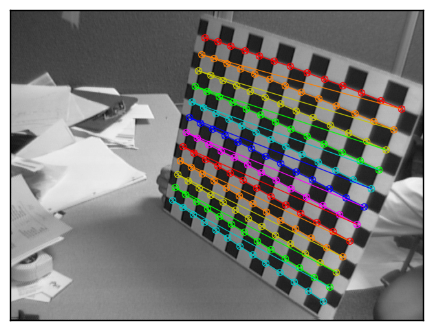

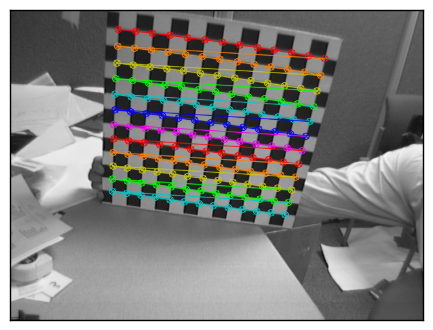

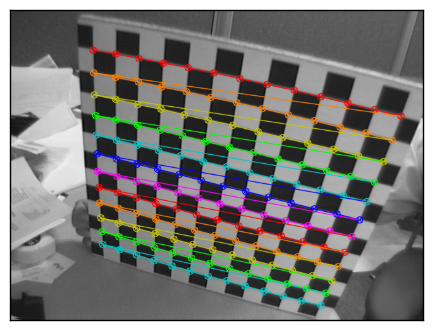

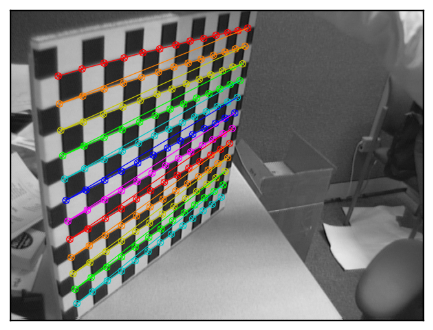

reprojection_error =  0.16213322860217477
camera = 
 [[ 657.43832609    0.          303.5279863 ]
 [   0.          657.93793031  241.2755271 ]
 [   0.            0.            1.        ]]
distorsion coeffs =  [[ -2.61357223e-01   1.64979065e-01  -4.45412857e-04  -9.03810232e-05
   -2.67425262e-02]]
rotation vecs = 
 [array([[ 0.32776985],
       [ 0.69006302],
       [ 0.3464442 ]]), array([[ 0.50130055],
       [ 0.01585551],
       [ 0.13779303]]), array([[ 0.60083153],
       [ 0.22724575],
       [ 0.18378143]]), array([[ 0.55948632],
       [-0.94914137],
       [-0.15426995]])]
tvecs = 
 [array([[ -0.08247399],
       [ -7.45511232],
       [ 24.29976001]]), array([[ -5.05471455],
       [ -7.79443188],
       [ 23.49678109]]), array([[ -4.52107825],
       [ -4.59761448],
       [ 16.34295371]]), array([[ -4.80625495],
       [ -2.90621911],
       [ 13.21066806]])]
refined camera = 
 [[ 599.88995361    0.          301.45775128]
 [   0.          597.3762207   240.58163871]
 [  

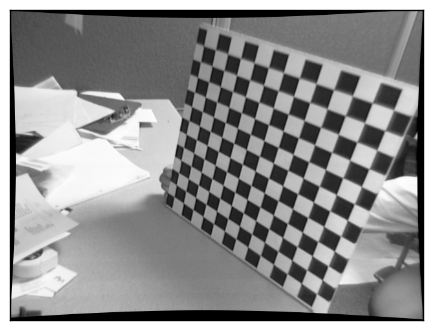

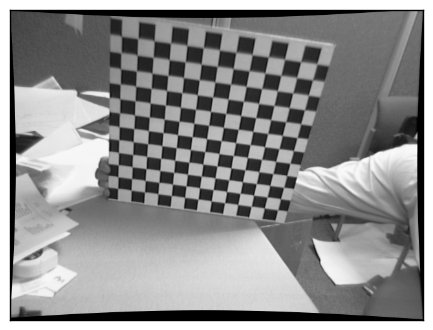

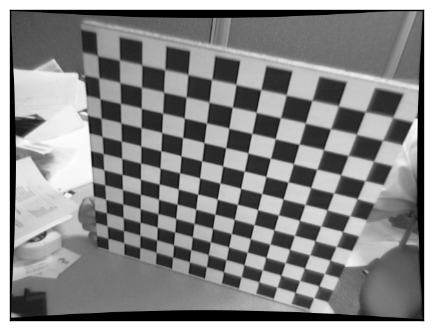

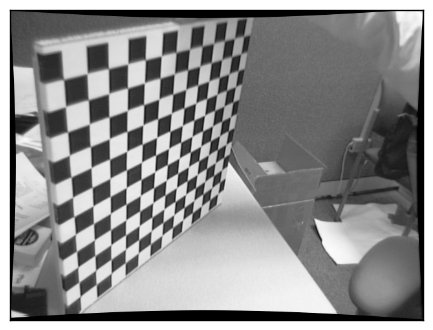

In [32]:
images = []
for i in range(1,26):
    images.append(cv2.imread('imagenes/Image'+str(i)+'.tif', 
                             flags=cv2.IMREAD_GRAYSCALE))

calibrate_camera_from(images,True)

#### Estimación de la matriz fundamental *F*

##### a) Obtener puntos en correspondencias sobre las imágenes Vmort[*].pgm de forma automática usando las funciones de BRISK/ORB.
##### b) Calcular F por el algoritmo de los 8 puntos + RANSAC (usar un valor pequeño para el error de RANSAC)
##### c) Dibujar las líneas epipolares sobre ambas imágenes. 
##### d) Verificar la bondad de la F estimada calculando la media de la distancia ortogonal entre los puntos soporte y sus líneas epipolares en ambas imágenes. Mostrar el valor medio del error.

a) Para obtener los puntos en correspondencia de las imágenes he definido la función ```get_matches```. Esta función recibe como parámetros las dos imágenes *Vmort* y obtiene los *keypoints* y sus descriptores usando BRISK y ORB. Una vez extraídos los keypoints, obtiene los puntos en correspondencia usando un *matcher* que utiliza la fuerza bruta y la validación cruzada para ambos descriptores. Al final la función compara el número de matches que se han obtenido usando BRISK y usando ORB, devolviendo los matches, keypoints y descriptores del que haya obtenido más puntos en correspondencia. Además, la función mostrará en una primera imagen todos los matches obtenidos y en una segunda el 15% mejor de los matches obtenidos.

In [33]:
def get_matches(image1, image2, show_imgs = True):
    # Vamos a inicializar un dectector ORB 
    # y un detector BRISK, y dejaremos aquel que obtenga
    # más puntos
    orb_detector = cv2.ORB_create()
    brisk_detector = cv2.BRISK_create()
    # Buscamos los keypoints y los descriptores de ambas
    # imágenes haciendo uso de ORB
    keyP1_orb, des1_orb = orb_detector.detectAndCompute(image1,None)
    keyP2_orb, des2_orb = orb_detector.detectAndCompute(image2,None)
    # Buscamos los keypoints y los descriptores de ambas
    # imágenes haciendo uso de BRISK
    keyP1_brisk, des1_brisk = brisk_detector.detectAndCompute(image1,None)
    keyP2_brisk, des2_brisk = brisk_detector.detectAndCompute(image2,None)
    # Inicializamos el BFMatcher con la norma Hamming para ORB y BRISK
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Hacemos matching entre los descriptores de ORB
    matches_orb = bf.match(des1_orb, des2_orb)
    # y para los de BRISK
    matches_brisk = bf.match(des1_brisk, des2_brisk)
    # Calculamos cuál ha obtenido más puntos en
    # correspondencias y nos quedamos con sus matches
    if len(matches_orb) > len(matches_brisk):
        matches = matches_orb
        kp1, kp2 = keyP1_orb, keyP2_orb
        des1, des2 = des1_orb, des2_orb
        print("Puntos en corresponencia usando ORB")
        print("Total de puntos: ", len(matches))
        
    else:
        matches = matches_brisk
        kp1, kp2 = keyP1_brisk, keyP2_brisk
        des1, des2 = des1_brisk, des2_brisk
        print("Puntos en corresponencia usando BRISK")
        print("Total de puntos: ", len(matches))
    
    if show_imgs:
        img_match = cv2.drawMatches(img1 = image1, keypoints1 = kp1,
                                    img2 = image2, keypoints2 = kp2, 
                                    matches1to2 = matches, outImg = None, flags=2)
        sorted_kp_img_match = cv2.drawMatches(img1 = image1, keypoints1 = kp1, 
                                              img2 = image2, keypoints2 = kp2, 
                                              matches1to2 = sorted(matches, key = lambda x:x.distance)[0:int(len(matches)*0.15)], 
                                              outImg = None, flags=2)
        print("Todas las correspondencias")
        fx.show_img_on_jupyter(img_match)
        print('El 15% de mejores puntos en corresponencias')
        fx.show_img_on_jupyter(sorted_kp_img_match)  
    
    return matches, kp1, des1, kp2, des2

* **Apartado b:** Según el libro *Multiple View Geometry*, dadas dos imágenes distintas de una misma escena, codifican una geometría epipolar que es independiente de la escena en sí, y sólo dependen de los parámetros internos de la cámara y su posición relativa. Esta geometría epipolar la codifica la matriz fundamental $F$, que es una matriz $3\times3$ con rango 2. Esta matriz fundamental satisface que $$x'^TFx = 0$$ donde $x$ y $x$ son puntos en correspondencias entre ambas imágenes, siendo una ecuación muy similar a la del cálculo de la homografía. Además, si la matriz $F$ está multiplicada por una constante es irrelevante ya que aun así codifica la misma geometría.

    Partiendo de esta ecuación, si disponemos de al menos 7 puntos en correspondencias entre ambas imágenes, podemos usarlos para determinar la matriz $F$ desconocida. Para empezar, pondremos los puntos como $x = (x,y,1)^T$ y $x' = (x',y',1)^T$. Siguiendo con esto y la ecuación $x'^TFx = 0$, tenemos que para cada punto tenemos una ecuación como la siguiente: $$x'xf_{11} + x'yf_{12} + x'f_{13}+y'xf_{21}+y'yf_{22} + y'f_{23} + xf_{31} + yf_{32} + f_{33} = 0$$
    Esto a su vez puede expresarse como: $$(x'x,x'y,x',y'x,y'y,y',x,y,1)f = 0$$

    Por tanto, si tenemos $n$ puntos tendremos que: $$Af = \left(\begin{matrix}
    x'_1x_1 & x'_1y_1 & x'_1 & y'_1x_1 & y'_1y_1 & y'_1 & x_1 & y_1 & 1\\
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
    x'_nx_n & x'_ny_n & x'_n & y'_nx_n & y'_ny_n & y'_n & x_n & y_n & 1\\
    \end{matrix}\right)f=0$$
    
    Además de esto, la matriz $F$ tiene 2 restricciones:
    * **$det(F) = 0$**
    * **La constante que multiplica a F es irrelevante**
    
Luego solo se necesitan 7 ecuaciones para determinar $F$. Para encontrar la matriz $F$, en vez de resolver el sistema, minimizamos $||Af||$ y para ello acudimos a la descomposición en valores singulares con el fin de obtener el autovector con menor autovalor de $A^TA$.

El método de los 8-puntos sustituye la matriz $F$ por una matriz $F'$ e intenta minimizar $||F - F'||$.
    

In [34]:
def estimate_fundamental_matrix_from(image1, image2):
    # Obtenemos los puntos en correspondencias
    matches, kp1, des1, kp2, des2 = get_matches(image1, image2)
    img_points1 = []
    img_points2 = []
    # Recuperamos las coordenadas de los puntos en correspondencias:
    for match in matches:
        img_points1.append(kp1[match.queryIdx].pt)
        img_points2.append(kp2[match.trainIdx].pt)
        
    img_points1 = np.array(img_points1, dtype=np.int32)
    img_points2 = np.array(img_points2, dtype=np.int32)
    # Psamos a obtener la matriz fundamental con el 
    # algoritmo de los 8 puntos usando RANSAC
    fundamental_mat, mask = cv2.findFundamentalMat(points1 = img_points1, 
                                             points2 = img_points2,
                                             method = cv2.FM_8POINT + cv2.FM_RANSAC, 
                                             param1 = 10**-2,
                                             param2 = 0.9999999)
    
    # Descartamos los puntos que son outliers
    img_points1 = img_points1[mask.ravel()==1]
    img_points2 = img_points2[mask.ravel()==1]
    print("Matriz fundamental F:\n",fundamental_mat)
    
    return fundamental_mat, img_points1, img_points2

* **Apartado c**: para dibujar las líneas epipolares, he definido la función ```show_epilines``` que recibe ambas imágenes y los *keypoints* de cada una de ellas y la matriz fundamental. Esta función hace uso de la función de *OpenCV* ```computeCorrespondEpilines``` que se encarga de obtener las líneas epipolares para cada una de las imágenes. Tras esto, con la función ```draw_epilines``` que he definido, muestro en una misma imagen las líneas epipolares en una de las dos imágenes y en la otra los puntos a los que corresponden esas líneas epipolares.

In [35]:
def draw_epilines(image1, img_points1, image2, img_points2, epilines):
    # Pasamos las imágenes de escala de grises a color para
    # poder representar las líneas epipolares de una manera
    # más clara
    aux_img1 = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    aux_img2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)
    
    for i in range(min(len(epilines),200)):
        # Generamos un color aleatorio
        line_color = tuple(np.random.randint(0,255,3).tolist())
        init_point = (0, int(-epilines[i][2]/epilines[i][1]))
        end_point = (image1.shape[1], int(-(epilines[i][2]+epilines[i][0]*image1.shape[1])/epilines[i][1]))
        # al tener definidos los dos puntos, podemos 
        # crear la línea epipolar que pasa por esos 
        # dos puntos
        aux_img1 = cv2.line(img = aux_img1, pt1 = init_point, 
                            pt2 = end_point, color = line_color,
                            thickness = 2)
        aux_img1 = cv2.circle(img = aux_img1, 
                              center=tuple(img_points1[i].astype(np.int64)), 
                              radius = 3, color = line_color)
        aux_img2 = cv2.circle(img = aux_img2, 
                              center=tuple(img_points2[i].astype(np.int64)), 
                              radius = 3, color = line_color)
    
    return aux_img1, aux_img2
    
def show_epilines(image1, img_points1, image2, img_points2, fundamental_mat):
    # Obtenemos las epilineas de ambas imágenes
    epipolarline_img1 = cv2.computeCorrespondEpilines(img_points1, 1, fundamental_mat).reshape(-1,3)
    epipolarline_img2 = cv2.computeCorrespondEpilines(img_points2, 2, fundamental_mat).reshape(-1,3)
    # Dibujamos las líneas epipolares
    # Lineas epipolares de la primera imagen sobre la segunda
    epip1, epip2 = draw_epilines(image1, img_points1, image2, img_points2, epipolarline_img2)
    canvas1 = np.zeros((epip1.shape[0],epip1.shape[1]+epip2.shape[1], 3), dtype = np.uint8)
    fx.insert_img_into_other(img_src=epip2, img_dest=canvas1,
                          pixel_left_top_row=0, pixel_left_top_col=0,
                          substitute=True)
    fx.insert_img_into_other(img_src=epip1, img_dest=canvas1,
                          pixel_left_top_row=0, pixel_left_top_col=epip1.shape[1],
                          substitute=True)
    
    # Lineas epipolares de la segunda imagen sobre la primera
    epip3, epip4 = draw_epilines(image2, img_points2, image1, img_points1, epipolarline_img1)
    canvas2 = np.zeros((epip3.shape[0],epip3.shape[1]+epip4.shape[1], 3), dtype = np.uint8)
    fx.insert_img_into_other(img_src=epip3, img_dest=canvas2,
                          pixel_left_top_row=0, pixel_left_top_col=0,
                          substitute=True)
    fx.insert_img_into_other(img_src=epip4, img_dest=canvas2,
                          pixel_left_top_row=0, pixel_left_top_col=epip1.shape[1],
                          substitute=True)
    # Mostramos ambas imágenes
    fx.show_img_on_jupyter(canvas1)
    fx.show_img_on_jupyter(canvas2)
    
    return epipolarline_img1, epipolarline_img2

Puntos en corresponencia usando BRISK
Total de puntos:  3435
Todas las correspondencias


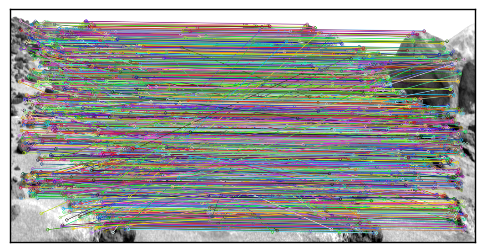

El 15% de mejores puntos en corresponencias


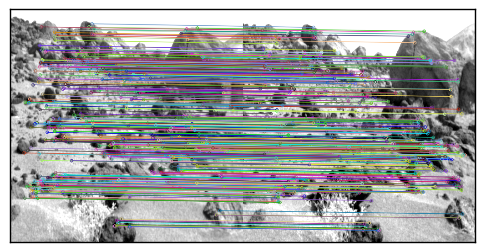

Matriz fundamental F:
 [[ -5.00487160e-10  -9.51311138e-06   7.04863209e-04]
 [  9.26678399e-06  -1.38342903e-06  -1.50659038e-01]
 [ -7.45117291e-04   1.51864378e-01   1.00000000e+00]]


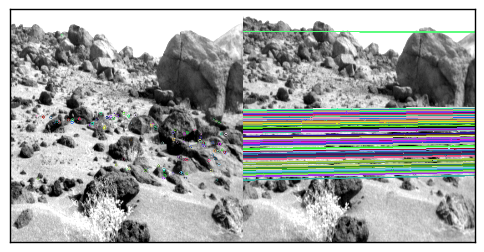

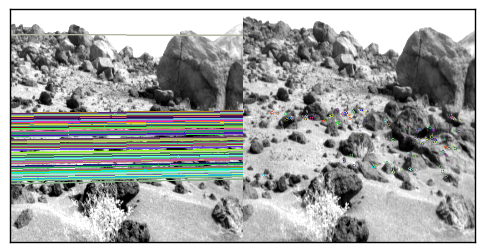

In [36]:
vmort1 = cv2.imread('imagenes/Vmort1.pgm', flags=cv2.IMREAD_GRAYSCALE)
vmort2 = cv2.imread('imagenes/Vmort2.pgm', flags=cv2.IMREAD_GRAYSCALE)
     
fundamental_mat, img_points1, img_points2 = estimate_fundamental_matrix_from(vmort1, vmort2)
    
epip1, epip2 = show_epilines(vmort1, img_points1, vmort2, img_points2, fundamental_mat)

En las imágenes podemos ver cómo las líneas los puntos de una imagen recaen sobre la línea epipolar dibujada en la otra imagen, con lo que podemos ver que la matriz fundamental que hemos calculado, junto con la línea epipolar calculada es bastante precisa.

* **Apartado d:** para calcular el error seguiremos el cálculo del error epipolar simétrico: $$error = \frac{\frac{\sum_{i=0}^n dst(pt1_i, epiline_1)}{n} + \frac{\sum_{i=0}^n dst(pt2_i, epiline_2)}{n}}{2}$$ y para calcular la distancia de un punto $p_i = (x_i, y_i)$ a su línea epipolar $l = ax + by + c$  hacemos: $$ d = \frac{|ax_i + by_i +c|}{\sqrt{a^2 + b^2}}$$ que podemos ver en el siguiente enlace de [Wikipedia](https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line). De esto se encarga la función ```epipolar_line_error```.

In [38]:
# Para calcular la bondad de F, usaremos el error
# epipolar simétrico
def epipolar_line_error(pts_im1, pts_im2, line_1, line_2):
    abs_value = math.fabs
    sqrt = math.sqrt
    # Función que calcula la distancia de un punto a una recta
    dst = lambda line, point: abs_value((line[0]*point[0] + line[1]*point[1] 
                                         + line[2])/sqrt(line[0]**2 + line[1]**2))
    
    dst_pt1_to_line1 = []
    dst_pt2_to_line2 = []
    # Recorremos los puntos calculando las distancias 
    # del punto a la línea
    for i in range(len(pts_im1)):
        dst_pt1_to_line1.append(dst(line_1[i], pts_im2[i]))
        dst_pt2_to_line2.append(dst(line_2[i], pts_im1[i]))
    
    # Calculamos el error:
    F_error = (np.mean(dst_pt1_to_line1) + np.mean(dst_pt2_to_line2))/2
    print("Error de F: ", F_error)
    return F_error


Para las imágenes anteriores y sus líneas epipolares, el error que obtenemos es el siguiente:

In [40]:
error = epipolar_line_error(img_points1, img_points2, epip1, epip2)

Error de F:  0.00419878753533


Como vemos, el error obtenido es de $4\cdot10^-3$, siendo un error pequeño, que indica que las líneas epipolares son bastante correctas.

#### Calcular el movimiento de la cámara (R,t) asociado a cada pareja de imágenes calibradas.
##### a) Usar las imágenes y datos de calibración dados en el fichero *reconstruccion.rar*.
##### b) Calcular parejas de puntos en correspondencias entre las imágenes.
##### c) Estimar la matriz esencial y calcular el movimiento.

* **Apartado a**: para leer los ficheros con la información sobre la cámara, he creado la función ```read_camera_file``` que recibe el nombre del fichero con la información de la cámara y devuelve la matriz cámara, la distorsión radial, la matriz de rotación y la matriz de translación como arrays de *NumPy*.

In [43]:
def read_camera_file(name):
    camera_matrix = []
    radial_distorsion = []
    rotation_matrix = []
    translation_matrix = []
    # Leemos el fichero para cargar los datos
    with open(name, 'r') as file:
        # Cargamos la matriz cámara
        for i in range(3):
            camera_matrix.append(file.readline().split(sep = " ")[:3])
        
        # Cargamos la distorsión radial
        radial_distorsion = file.readline().split(sep = " ")
        
        # Cargamos la matriz de rotación
        for i in range(3):
            rotation_matrix.append(file.readline().split(sep = " ")[:3])
        
        # Cargamos la matriz translación
        translation_matrix = file.readline().split(sep = " ")
        
    # Pasamos las listas a arrays de NumPy
    camera_matrix = np.array(camera_matrix, dtype=np.float32)
    radial_distorsion = np.array(radial_distorsion, dtype=np.float32)
    rotation_matrix = np.array(camera_matrix, dtype=np.float32)
    translation_matrix = np.array(camera_matrix, dtype=np.float32)
    

    return camera_matrix, radial_distorsion, rotation_matrix, translation_matrix

In [45]:
camera_file_names = ['imagenes/rdimage.000.ppm.camera',
                     'imagenes/rdimage.001.ppm.camera',
                     'imagenes/rdimage.004.ppm.camera',
                    ]

camera_matrix00, radial_distorsion00, rotation_matrix00, translation_matrix00 = \
    read_camera_file(camera_file_names[0])
camera_matrix01, radial_distorsion01, rotation_matrix01, translation_matrix01 = \
    read_camera_file(camera_file_names[1])
camera_matrix04, radial_distorsion04, rotation_matrix04, translation_matrix04 = \
    read_camera_file(camera_file_names[2])

* **Apartado b**: para calcular los puntos en correspondencia entre las tres imágenes, en vez de llamar a la función definidia anteriormente ```get_matches```, en esta ocasión he definido una nueva función para evitar tener objetos repetidos en memoria. Esta función es ```get_matches_of_3``` que recibe las tres imágenes y obtiene los puntos en corresponencias entre las tres imágenes.

In [49]:
def get_matches_of_3(image1, image2, image3, show = False):
    # Inicializamos el detector BRISK
    brisk_detector = cv2.BRISK_create()
    # Obtenemos los keypoints y sus descriptores
    kp1, des1 = brisk_detector.detectAndCompute(image1,None)
    kp2, des2 = brisk_detector.detectAndCompute(image2,None)
    kp3, des3 = brisk_detector.detectAndCompute(image3,None)
    # Inicializamos el matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Obtenemos los puntos en corresponencia entre
    # cada par de imágenes
    matches1to2 = bf.match(des1, des2)
    matches1to3 = bf.match(des1, des3)
    matches2to3 = bf.match(des2, des3)
    # Si el flag show está activo se 
    # muestran las imágenes por pantalla con 
    # algunos de los mejores matches
    
    if show:
        some_matches_1to2 = cv2.drawMatches(img1 = image1, keypoints1 = kp1, 
                                            img2 = image2, keypoints2 = kp2, 
                                            matches1to2 = sorted(matches1to2, key = lambda x:x.distance)[0:int(len(matches1to2)*0.15)], 
                                            outImg = None, flags=2)
        some_matches_1to3 = cv2.drawMatches(img1 = image1, keypoints1 = kp1, 
                                            img2 = image3, keypoints2 = kp3, 
                                            matches1to2 = sorted(matches1to3, key = lambda x:x.distance)[0:int(len(matches1to3)*0.15)], 
                                            outImg = None, flags=2)
        some_matches_2to3 = cv2.drawMatches(img1 = image2, keypoints1 = kp2, 
                                            img2 = image3, keypoints2 = kp3, 
                                            matches1to2 = sorted(matches2to3, key = lambda x:x.distance)[0:int(len(matches2to3)*0.15)], 
                                            outImg = None, flags=2)
        print('El 15% de mejores puntos en corresponencias')
        fx.show_img_on_jupyter(some_matches_1to2)
        print('El 15% de mejores puntos en corresponencias')
        fx.show_img_on_jupyter(some_matches_1to3)  
        print('El 15% de mejores puntos en corresponencias')
        fx.show_img_on_jupyter(some_matches_2to3)  

    return kp1, des1, kp2, des2, kp3, des3, matches1to2, matches1to3, matches2to3

El 15% de mejores puntos en corresponencias


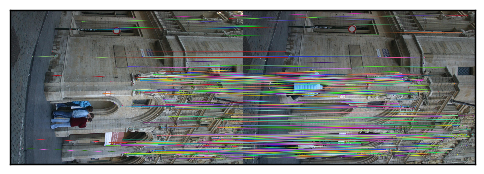

El 15% de mejores puntos en corresponencias


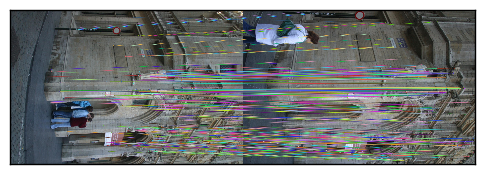

El 15% de mejores puntos en corresponencias


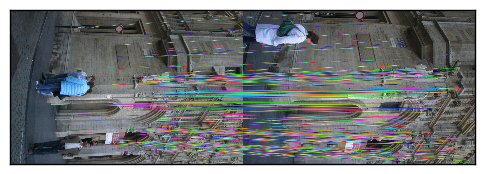

In [50]:
rdimages000 = cv2.imread('imagenes/rdimage.000.ppm', flags=cv2.IMREAD_COLOR) 
rdimages001 = cv2.imread('imagenes/rdimage.001.ppm', flags=cv2.IMREAD_COLOR)
rdimages004 = cv2.imread('imagenes/rdimage.004.ppm', flags=cv2.IMREAD_COLOR)

kp1, des1, kp2, des2, kp3, des3, matches1to2, matches1to3, matches2to3 = \
    get_matches_of_3(rdimages000, rdimages001, rdimages004, show=True)

* **Apartado c**: una vez obtenidos los keypoints de cada imagen, los puntos en correspondencia entre las distintas imágenes, podemos pasar a realizar el cálculo del movimiento entre las distintas cámaras. Este cálculo se hace tomando como referencia una de las cámaras, teniendo como matriz de rotación la matriz identidad y translación 0, y calculando las matrices de translación y rotación del resto de cámaras respecto de la primera.